In [1]:
import os
import numpy as np
import torch
from nilearn import plotting
import data
import visualize
from words import make_classifications, Predictions
from data import normalize_fmri_data, unnormalize_fmri_data
from LEM import extract_data_features, predAccuracy
from numpy.linalg import norm


In [2]:
class argObj:
    def __init__(self, data_dir, parent_submission_dir, subj):
        self.subj = format(subj, '02')
        self.data_dir = os.path.join(data_dir, 'subj' + self.subj)
        self.parent_submission_dir = parent_submission_dir
        self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                                                   'subj' + self.subj)


In [3]:
platform = 'jupyter_notebook'
device = 'cuda'
device = torch.device('cuda')
# setting up the directories and ARGS
data_dir = 'C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/'#../MQP/algonauts_2023_challenge_data/'
parent_submission_dir = '../submission'
subj = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
# args

args = argObj(data_dir, parent_submission_dir, subj)
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']


In [4]:
words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']

In [4]:
print("________ Process Data ________")

# Normalize Data Before Split
lh_fmri, lh_data_min, lh_data_max = normalize_fmri_data(lh_fmri)
print(lh_fmri)
print("- - - - - - - -")
rh_fmri, rh_data_min, rh_data_max = normalize_fmri_data(rh_fmri)
print(rh_fmri)

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

train_img_dir = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir = os.path.join(args.data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
train_img_list = train_img_list[:1000]
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()

print('\nTraining images: ' + str(len(train_img_list)))
print('\nTest images: ' + str(len(test_img_list)))
train_img_file = train_img_list[0]
print('\nTraining image file name: ' + train_img_file)
print('\n73k NSD images ID: ' + train_img_file[-9:-4])

________ Process Data ________
-2.515819 2.4762304
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.62769     0.55193     0.67142 ...     0.69863     0.72638     0.71742]
 [    0.44796     0.47105     0.62229 ...     0.55655     0.54892     0.62596]
 [    0.22312     0.42925     0.37006 ...     0.63066     0.60185     0.55653]]
- - - - - - - -
-2.5166664 2.4293716
[[    0.87571     0.39814     0.50907 ...     0.42413     0.38705     0.37228]
 [    0.61258     0.70873     0.49787 ...     0.80909     0.83579     0.84486]
 [    0.75225     0.48751     0.24973 ...     0.58831     0.62981     0.64943]
 ...
 [    0.50022     0.60346     0.57408 ...     0.57377     0.50956     0.43088]
 [    0.84737     0.50435      0.4118 ...     0.49836      0.5347     0.54115]
 [     0.4397     0.60309     0.

In [5]:
print("________ Split Data ________")

idxs_train, idxs_val, idxs_test = splitdata(train_img_list, test_img_list, train_img_dir)
lh_fmri_train = lh_fmri[idxs_train]
rh_fmri_train = rh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_test = rh_fmri[idxs_test]

________ Split Data ________
Training stimulus images: 900

Validation stimulus images: 100

Test stimulus images: 159


In [6]:
print("________ Make Lists ________")

train_images = makeList(train_img_dir, train_img_list, idxs_train)
val_images = makeList(train_img_dir, train_img_list, idxs_val)
test_images = makeList(test_img_dir, test_img_list, idxs_test)
torch.cuda.empty_cache()

________ Make Lists ________


In [ ]:
print("________ Make Classifications ________")
lh_classifications = make_classifications(train_images, idxs_train, device)
rh_classifications = lh_classifications
lh_classifications_val = make_classifications(val_images, idxs_val, device)
rh_classifications_val = lh_classifications_val
lh_classifications_test = make_classifications(test_images, idxs_test, device)
rh_classifications_test = lh_classifications_test

torch.cuda.empty_cache()

In [ ]:
print("________ Extract Image Features ________")

train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader = (
    transformData(train_img_dir, test_img_dir, idxs_train, idxs_val, idxs_test, 64))

features_train, trainImagePaths, features_val, validImagePaths, features_test, testImagePaths = (
    extract_data_features(train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader, 64))

________ Extract Image Features ________


Extracting Features: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Training images features:
(8857, 64)
(Training stimulus images × PCA features)

Validation images features:
(984, 64)
(Validation stimulus images × PCA features)

Test images features:
(159, 64)
(Test stimulus images × PCA features)


In [ ]:
print("________ Organize Input________")

dftrainL, dftrainFL = organize_input(lh_classifications, features_train, trainImagePaths, lh_fmri_train)
dftrainR, dftrainFR = organize_input(rh_classifications, features_train, trainImagePaths, rh_fmri_train)

dfvalL, dfvalFL = organize_input(lh_classifications_val, features_val, validImagePaths, lh_fmri_val)
dfvalR, dfvalFR = organize_input(rh_classifications_val, features_val, validImagePaths, rh_fmri_val)

dftestL, dftestFL = organize_input(lh_classifications_test, features_test, testImagePaths, lh_fmri_test)
dftestR, dftestFR = organize_input(rh_classifications_test, features_test, testImagePaths, rh_fmri_test)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from ultralytics import YOLO
from gradCam.models import roiVGGYolo
from torchvision import transforms

In [ ]:
yoloTsfms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])


lModel = roiVGGYolo(dftrainFL.shape[0], yoloTsfms).to("cuda:1")
rModel = roiVGGYolo(dftrainFL.shape[0], yoloTsfms).to("cuda:1")

In [ ]:
class fuckingBitchAssDataset(Dataset):
    def __init__(self, val):
        self.val = val.iloc[:, :-1].to_numpy(dtype=np.float32)
        self.imagePaths = val.iloc[:, -1].to_numpy()
    def __len__(self):
        return len(self.val)
    def __getitem__(self, index):
        return self.val[index], self.imagePaths[index]

In [ ]:
def RoiVGGYoloPredictions(val, val_fmri, model):
    print("RoiVGGYoloPredictions")
    dataset = fuckingBitchAssDataset(val)
    # image_paths = val.iloc[:, -1].to_numpy()
    # val = val.iloc[:, :-1].to_numpy(dtype=float)
    val_fmri = val_fmri.to_numpy(dtype=float)
    # features_tensor = torch.tensor(val, dtype=torch.float32)  # Convert only feature columns
    # dataset = TensorDataset(validDataSet, torch.from_numpy(image_paths))  # Use torch.from_numpy for image_paths
    print("here")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            # print(data)
            # print(data[0].shape)
            # print(data[1].shape)
            # print(data.shape)
            features = data[0].to("cuda:1")
            image_paths = data[1]
            pred = model(features, image_paths)
            predictions.push(pred)
    print(val_fmri, "\n _ _ _ _ _ _ _ _ _ _ _ _ _ _ _\n", predictions)
    linear_regression_mse = mean_squared_error(val_fmri, predictions)
    print(f'Random Forest Mean Squared Error: {linear_regression_mse}')
    return predictions

In [10]:
print("________ Predictions Validation ________")
lh_fmri_val_pred = RoiVGGYoloPredictions(dfvalL, dfvalFL,lModel)
rh_fmri_val_pred = RoiVGGYoloPredictions(dfvalR, dfvalFR)

________ Predictions Validation ________
PREDICTIONS
[[    0.58582     0.46208     0.55602 ...     0.44695      0.4853     0.39012]
 [    0.53031     0.41261     0.20612 ...     0.38756     0.31653     0.46265]
 [     0.5813     0.64572     0.65082 ...     0.50731     0.49914     0.45125]
 ...
 [    0.20881       0.295     0.47646 ...     0.36801     0.29388     0.39038]
 [     0.5874     0.46502     0.63557 ...     0.48936     0.48192     0.58774]
 [    0.60275     0.54152     0.52044 ...     0.54478     0.66644     0.52105]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.54284     0.55622     0.62617 ...     0.59834     0.59137     0.55541]
 [    0.49799     0.46861     0.45105 ...     0.48964     0.49052     0.49499]
 [    0.55867     0.56202     0.54528 ...     0.51152     0.52237     0.49661]
 ...
 [    0.50769     0.46251     0.42856 ...     0.41436     0.42375     0.45352]
 [     0.5192     0.49442     0.47075 ...     0.50641     0.50684     0.51204]
 [    0.57642     0.51573     0.39

In [11]:
print("________ Predictions Test________")
lh_fmri_test_pred = Predictions(dftrainL, dftrainFL, dftestL, dftestFL)
rh_fmri_test_pred = Predictions(dftrainR, dftrainFR, dftestR, dftestFR)

________ Predictions Test________
PREDICTIONS
[[    0.33133     0.46326     0.37849 ...      0.2802     0.31058     0.48424]
 [    0.64868     0.44725     0.68909 ...     0.73208     0.73593     0.78369]
 [    0.44218     0.31722     0.84834 ...     0.43348     0.40331     0.46675]
 ...
 [    0.31642     0.28488     0.37538 ...     0.38776     0.34312     0.41256]
 [    0.41328     0.53082     0.62215 ...      0.7056     0.70056     0.66135]
 [    0.59368     0.51872      0.7144 ...     0.37513     0.32682      0.2032]] 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
 [[    0.53204     0.46033      0.3801 ...      0.5252     0.51887     0.55865]
 [    0.48874      0.4872     0.56344 ...     0.60145     0.58863     0.56765]
 [    0.48249     0.46559     0.50357 ...     0.49641      0.4874     0.49456]
 ...
 [    0.48849     0.48393      0.6753 ...     0.58147     0.57236     0.54808]
 [    0.50198     0.49788      0.3964 ...     0.40099     0.40805     0.44135]
 [    0.45664      0.4671     0.54047 ...

In [12]:
print("________ Unnormalize Data ________")

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, lh_data_min, lh_data_max)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, rh_data_min, rh_data_max)
lh_fmri_test_pred = unnormalize_fmri_data(lh_fmri_test_pred, lh_data_min, lh_data_max)
rh_fmri_test_pred = unnormalize_fmri_data(rh_fmri_test_pred, rh_data_min, rh_data_max)


________ Unnormalize Data ________


In [8]:
allLhIndices = np.load("./VisRun/combinedLossIndices.npy")
allRhIndices = np.load("./VisRun/validIdxsRh.npy")


In [9]:
allLhIndices = allLhIndices.astype(int)
allRhIndices = allRhIndices.astype(int)

In [12]:
# allLhIndices

In [13]:
lh_classifications_val = np.load("./VisRun/goodClassifications.npy")[allLhIndices]
# rh_classifications_val = np.load("./VisRun/lhClassificationPred.npy")[allRhIndices]

In [9]:
lh_classifications_val.shape

(975, 2)

In [5]:
fmri_dir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/subj01/training_split/training_fmri"

In [6]:
from sklearn.model_selection import train_test_split, KFold
# k_folds = 5
# skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

#Get the validation indexes used for the fold that resulted in the best params
_, validationIdxs = train_test_split(range(9841), train_size=0.9, random_state = 42)
# list(skf.split(np.arange(9841)))[4][1]

In [7]:
validationIdxs = np.array(validationIdxs)

In [19]:
print("________ Re-Load Data ________")
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

lh_fmri_val = lh_fmri[validationIdxs[allLhIndices]]
rh_fmri_val = rh_fmri[:10]

lh_fmri_val_pred = np.load("./VisRun/combinedLossLhPrediction.npy")
rh_fmri_val_pred = np.load("./VisRun/rhFMRIPred.npy")[:10]

# lh_fmri_test = lh_fmri[idxs_train]
# rh_fmri_test = rh_fmri[idxs_train]
# print(lh_fmri_test)


________ Re-Load Data ________


In [20]:
lh_fmri_val_pred

array([[  0.0080971,  -0.0070947,  -0.0042465, ...,   -0.012395,     0.01271,   -0.011214],
       [   0.056679,   -0.049663,   -0.029726, ...,   -0.086765,    0.088972,   -0.078496],
       [   0.072874,   -0.063852,   -0.038219, ...,    -0.11155,     0.11439,    -0.10092],
       ...,
       [   0.024291,   -0.021284,    -0.01274, ...,   -0.037185,    0.038131,   -0.033641],
       [   0.032388,   -0.028379,   -0.016986, ...,    -0.04958,    0.050841,   -0.044855],
       [    0.16194,    -0.14189,    -0.08493, ...,     -0.2479,     0.25421,    -0.22427]], dtype=float32)

In [16]:

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, -2.515819, 2.4762304)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, -2.5166664, 2.4293716)

In [21]:
print("________ Prediction Accuracy ________")

lh_correlation, rh_correlation = predAccuracy(lh_fmri_val_pred, lh_fmri_val, rh_fmri_val_pred, rh_fmri_val)


________ Prediction Accuracy ________
Start PredAccuracy

predicted
 [[  0.0080971  -0.0070947  -0.0042465 ...   -0.012395     0.01271   -0.011214]
 [   0.056679   -0.049663   -0.029726 ...   -0.086765    0.088972   -0.078496]
 [   0.072874   -0.063852   -0.038219 ...    -0.11155     0.11439    -0.10092]
 ...
 [   0.024291   -0.021284    -0.01274 ...   -0.037185    0.038131   -0.033641]
 [   0.032388   -0.028379   -0.016986 ...    -0.04958    0.050841   -0.044855]
 [    0.16194    -0.14189    -0.08493 ...     -0.2479     0.25421    -0.22427]] 
actual
 [[    0.40555    -0.54157   -0.048368 ...    -0.32394    -0.40157     0.10533]
 [   -0.33966     0.86755    0.051938 ...      1.5427      1.4666     0.47781]
 [   0.082277    -0.67769    0.097822 ...      0.1655     0.34329     0.27515]
 ...
 [   0.062567    0.018855    -0.91235 ...    -0.43393     0.10243     -1.0122]
 [   -0.20217    -0.89535     -1.3222 ...     -0.8487    -0.61484    -0.70999]
 [    0.46031     0.55694    -0.35021 ... 

100%|██████████| 20544/20544 [00:12<00:00, 1662.06it/s]

average lh  0.040162983424795864 average rh  0.8396608939500949


c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


________ Visualize Each Class ________
0 furniture
[   0.056455   -0.049466   -0.029608 ...    -0.08642    0.088619   -0.078184]
[  -0.021747    -0.21134   -0.098292 ...     0.11596    0.099327    -0.12221]


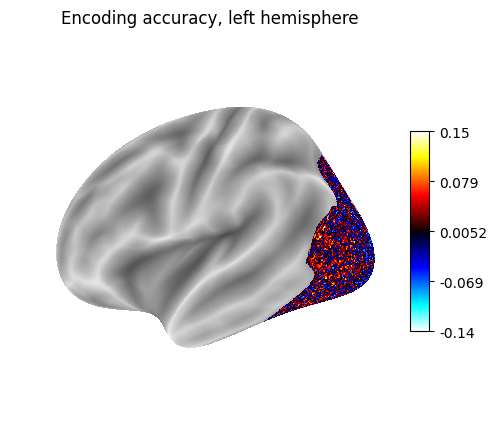

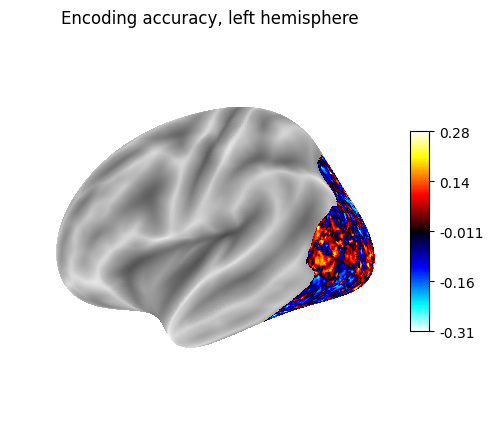

36
Corre  0.2557226046760254
Cosine Similarity: 0.017371062
1 food
[   0.039933    -0.03499   -0.020943 ...    -0.06113    0.062685   -0.055304]
[   0.012031   0.0045496  -0.0073229 ...   -0.034257   -0.028462   -0.059272]


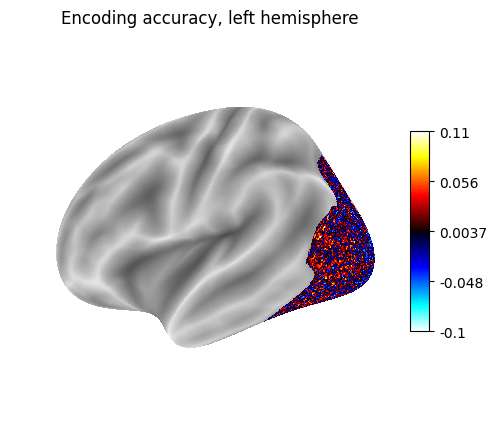

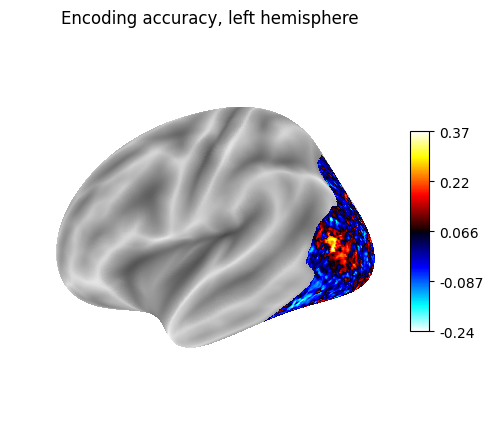

44
Corre  0.2540622588641607
Cosine Similarity: 0.0041757156
2 kitchenware
[   0.062077   -0.054393   -0.032557 ...   -0.095028    0.097446   -0.085971]
[    -0.0487    0.092315    -0.20461 ...   -0.019889    0.014543   -0.082915]


KeyboardInterrupt: 

In [22]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_val)):

        if lh_classifications_val[i][1] == clss:
            avg_lh_pred.append(lh_fmri_val_pred[i])
            avg_lh_real.append(lh_fmri_val[i])

        # if rh_classifications_val[i][1] == clss:
        #     avg_rh_pred.append(rh_fmri_val_pred[i])
        #     avg_rh_real.append(lh_fmri_val[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

In [16]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    print(clss, words[clss])
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_test)):

        if lh_classifications_test[i][1] == clss:
            avg_lh_pred.append(lh_fmri_test_pred[i])
            avg_lh_real.append(lh_fmri_test[i])

        if rh_classifications[i][1] == clss:
            avg_rh_pred.append(rh_fmri_test_pred[i])
            avg_rh_real.append(lh_fmri_test[i])

    if(len(avg_lh_pred)  == 0):
        pass
    else:
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)

        #print("MEAN PRED LH:\n", lh)
        #print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh)
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)

        #print("MEAN REAL LH:\n", lh2)
        #print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2)
        plotting.show()

        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))
        cosine = np.dot(lh,lh2)/(norm(lh)*norm(lh2))
        print("Cosine Similarity:", cosine)
        torch.cuda.empty_cache()

print("________ END ________")

________ Visualize Each Class ________
0 furniture


KeyboardInterrupt: 